# Some preprocessing to implement tanh in generator

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
# # 4 samples/observations and 2 variables/features
# data = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
# 
# scaled_data = scaler.fit_transform(data)

In [20]:
# normalized_df=(df-df.mean())/df.std()
df = pd.read_csv('train.csv')
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]
df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
df.Sex = df.Sex.replace({'male':0,'female':1})
df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})

# Importing the dependencies

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns

# Creating pytorch dataset and dataloader

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
class MyDataset(Dataset):
 
  def __init__(self):
    df = pd.read_csv('train.csv')
    df["label"] = df.Survived
    df = df[df['label'] == 1].reset_index(drop = True)
    df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
    # handling missing values
    median_age = df.Age.median()
    mode_embarked = df.Embarked.mode()[0]
    df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
    df.Sex = df.Sex.replace({'male':0,'female':1})
    df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})
 
    x = df.iloc[:, 0:7].values
    y = df.iloc[:, -1].values
 
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset()

In [4]:
batch_size = 64


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [6]:
train_dl = DeviceDataLoader(train_dl, device)

In [7]:
train_dl.device

device(type='cuda')

# Creating generator and discriminator models

<b> Generator Architecture

In [8]:
latent_size = 7

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
#             nn.Linear(latent_size, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 7),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = to_device(Generator(), device)

<b> Discriminator Architecture

In [10]:
n_features = 7

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
#             nn.Linear(n_features, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 1),
#             nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = to_device(Discriminator(), device)

# Generator and discriminator training methodology

In [27]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(real_data, opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
    # real data ko labels set to 1
    real_labels = torch.ones((cur_batch_size),  device = device)
    # passing real images through discriminator
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    
    # fake data ko labels set to 0
    fake_labels = torch.zeros((cur_batch_size),  device = device)
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds, fake_labels)
    
    loss = d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [28]:
def train_generator(opt_g, cur_batch_size):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # fake data ko labels set to 1
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)

    g_loss.backward()
    opt_g.step()
    return g_loss

# Training Loop

In [29]:
lr = 0.001
epochs = 100
# nn.BCELoss() use nagarne, kinaki yo method ma builtin sigmoid function use hudena, [0,1] ma leudena outputs lai
# so, F.binary_cross_entropy use garda best, tara maile sigmoid use garxu esma
criterion = nn.BCELoss()

In [30]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
opt_g = torch.optim.Adam(generator.parameters(), lr=lr)

In [31]:
def fit(epochs, lr, opt_d, opt_g):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []

    
    # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    total_step = len(train_dl)
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(train_dl):
            cur_batch_size = real_data.shape[0]

            # Train the discriminator and generator
            d_loss = train_discriminator(real_data, opt_d, cur_batch_size)
            g_loss = train_generator(opt_g, cur_batch_size)

            losses_d.append(d_loss.item())
            losses_g.append(g_loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item()))

    return losses_g, losses_d

In [32]:
history = fit(epochs, lr, opt_d, opt_g)

Epoch [0/100], Step [1/6], d_loss: 1.5923, g_loss: 0.6230
Epoch [0/100], Step [2/6], d_loss: 1.2864, g_loss: 0.7079
Epoch [0/100], Step [3/6], d_loss: 1.2429, g_loss: 0.7603
Epoch [0/100], Step [4/6], d_loss: 1.0065, g_loss: 0.8413
Epoch [0/100], Step [5/6], d_loss: 1.1455, g_loss: 0.9333
Epoch [0/100], Step [6/6], d_loss: 1.2343, g_loss: 0.9250
Epoch [1/100], Step [1/6], d_loss: 1.1519, g_loss: 0.8591
Epoch [1/100], Step [2/6], d_loss: 1.0602, g_loss: 0.8432
Epoch [1/100], Step [3/6], d_loss: 0.9430, g_loss: 0.8037
Epoch [1/100], Step [4/6], d_loss: 1.0590, g_loss: 0.8490
Epoch [1/100], Step [5/6], d_loss: 1.0182, g_loss: 0.9217
Epoch [1/100], Step [6/6], d_loss: 1.2133, g_loss: 0.8948
Epoch [2/100], Step [1/6], d_loss: 1.0289, g_loss: 0.8722
Epoch [2/100], Step [2/6], d_loss: 1.0576, g_loss: 0.9312
Epoch [2/100], Step [3/6], d_loss: 1.1766, g_loss: 0.9166
Epoch [2/100], Step [4/6], d_loss: 0.9382, g_loss: 0.9106
Epoch [2/100], Step [5/6], d_loss: 1.0887, g_loss: 0.9434
Epoch [2/100],

Epoch [26/100], Step [1/6], d_loss: 0.7508, g_loss: 1.1909
Epoch [26/100], Step [2/6], d_loss: 0.7185, g_loss: 1.2714
Epoch [26/100], Step [3/6], d_loss: 0.5710, g_loss: 1.3871
Epoch [26/100], Step [4/6], d_loss: 0.6519, g_loss: 1.3436
Epoch [26/100], Step [5/6], d_loss: 0.6423, g_loss: 1.5283
Epoch [26/100], Step [6/6], d_loss: 0.4855, g_loss: 1.5032
Epoch [27/100], Step [1/6], d_loss: 0.7030, g_loss: 1.3719
Epoch [27/100], Step [2/6], d_loss: 0.4892, g_loss: 1.4478
Epoch [27/100], Step [3/6], d_loss: 0.6599, g_loss: 1.5469
Epoch [27/100], Step [4/6], d_loss: 0.6731, g_loss: 1.5349
Epoch [27/100], Step [5/6], d_loss: 0.5419, g_loss: 1.4180
Epoch [27/100], Step [6/6], d_loss: 0.6834, g_loss: 1.4919
Epoch [28/100], Step [1/6], d_loss: 0.4972, g_loss: 1.4512
Epoch [28/100], Step [2/6], d_loss: 0.6555, g_loss: 1.5756
Epoch [28/100], Step [3/6], d_loss: 0.5857, g_loss: 1.4512
Epoch [28/100], Step [4/6], d_loss: 0.7808, g_loss: 1.6042
Epoch [28/100], Step [5/6], d_loss: 0.7144, g_loss: 1.73

Epoch [50/100], Step [6/6], d_loss: 1.4892, g_loss: 0.9688
Epoch [51/100], Step [1/6], d_loss: 1.2105, g_loss: 1.0238
Epoch [51/100], Step [2/6], d_loss: 1.1448, g_loss: 1.0004
Epoch [51/100], Step [3/6], d_loss: 1.1967, g_loss: 1.0462
Epoch [51/100], Step [4/6], d_loss: 1.0409, g_loss: 0.9641
Epoch [51/100], Step [5/6], d_loss: 1.1584, g_loss: 0.9670
Epoch [51/100], Step [6/6], d_loss: 1.2257, g_loss: 0.8113
Epoch [52/100], Step [1/6], d_loss: 1.1413, g_loss: 0.9461
Epoch [52/100], Step [2/6], d_loss: 1.2109, g_loss: 0.8756
Epoch [52/100], Step [3/6], d_loss: 1.1623, g_loss: 0.9312
Epoch [52/100], Step [4/6], d_loss: 1.0617, g_loss: 0.9386
Epoch [52/100], Step [5/6], d_loss: 0.9728, g_loss: 0.9610
Epoch [52/100], Step [6/6], d_loss: 0.9838, g_loss: 0.9843
Epoch [53/100], Step [1/6], d_loss: 1.0075, g_loss: 0.9570
Epoch [53/100], Step [2/6], d_loss: 1.0080, g_loss: 0.9894
Epoch [53/100], Step [3/6], d_loss: 0.8929, g_loss: 0.9893
Epoch [53/100], Step [4/6], d_loss: 0.9525, g_loss: 1.04

Epoch [76/100], Step [2/6], d_loss: 1.3826, g_loss: 0.9802
Epoch [76/100], Step [3/6], d_loss: 1.3224, g_loss: 1.0068
Epoch [76/100], Step [4/6], d_loss: 1.1418, g_loss: 0.9650
Epoch [76/100], Step [5/6], d_loss: 1.2540, g_loss: 0.8899
Epoch [76/100], Step [6/6], d_loss: 1.0457, g_loss: 0.8497
Epoch [77/100], Step [1/6], d_loss: 1.1361, g_loss: 0.9300
Epoch [77/100], Step [2/6], d_loss: 1.0290, g_loss: 0.9710
Epoch [77/100], Step [3/6], d_loss: 1.1469, g_loss: 0.9871
Epoch [77/100], Step [4/6], d_loss: 1.0935, g_loss: 0.9903
Epoch [77/100], Step [5/6], d_loss: 1.0352, g_loss: 1.0572
Epoch [77/100], Step [6/6], d_loss: 0.8262, g_loss: 1.0119
Epoch [78/100], Step [1/6], d_loss: 1.0538, g_loss: 1.0980
Epoch [78/100], Step [2/6], d_loss: 0.9975, g_loss: 1.0203
Epoch [78/100], Step [3/6], d_loss: 1.0062, g_loss: 1.0649
Epoch [78/100], Step [4/6], d_loss: 1.0447, g_loss: 1.0881
Epoch [78/100], Step [5/6], d_loss: 1.0706, g_loss: 1.1340
Epoch [78/100], Step [6/6], d_loss: 0.9698, g_loss: 1.14

# Testing Generated Samples from Trained Generator

In [21]:
number_of_samples_to_generate = df[df.label == 0].shape[0] - df[df.label == 1].shape[0]

In [22]:
# number_of_samples_to_generate

In [33]:
latent_space_samples = torch.randn(number_of_samples_to_generate, 7).to(device)
generated_samples = generator(latent_space_samples)
generated_samples = torch.concat([generated_samples, torch.ones((number_of_samples_to_generate, 1)).to('cuda')], dim = 1)
generated_samples = generated_samples.cpu().detach().numpy()
df_generated = pd.DataFrame(generated_samples, columns = df.columns)

<AxesSubplot:>

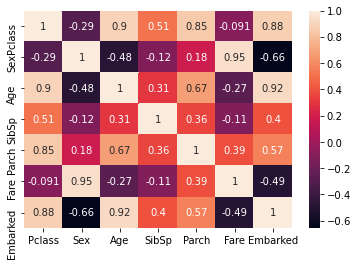

In [34]:
sns.heatmap(df_generated[df_generated.columns[:-1]].corr(), annot = True)

<AxesSubplot:>

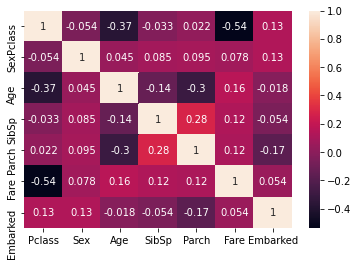

In [35]:
ones = df[df.label == 1]
sns.heatmap(ones[ones.columns[:-1]].corr(), annot = True)

In [46]:
def generate_samples(number_of_samples_to_generate):
    latent_space_samples = torch.randn(number_of_samples_to_generate, 7).to(device)
    generated_samples = generator(latent_space_samples)
    generated_samples = torch.concat([generated_samples, torch.ones((number_of_samples_to_generate, 1)).to('cuda')], dim = 1)
    generated_samples = generated_samples.cpu().detach().numpy()
    df_generated = pd.DataFrame(generated_samples, columns = df.columns)
    
    return df_generated

# Check accuracy of model on balanced and imbalanced dataset

In [75]:
X = df[df.columns.to_list()[:-1]]
y = df['label']

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.4)
X_train['label'] = y_train
X_train.reset_index(drop = True, inplace = True)

In [77]:
X_train.label.value_counts()

0    333
1    201
Name: label, dtype: int64

In [78]:
X_train_gen = X_train.copy()
number_of_samples_to_generate = 333 - 201
X_train_gen = pd.concat([X_train_gen, generate_samples(number_of_samples_to_generate)]).reset_index(drop = True)
X_train_gen['label'] = X_train_gen['label'].map(int)

In [79]:
X_train_gen.label.value_counts()

1    333
0    333
Name: label, dtype: int64

<b> Training with XGBOOST

In [80]:
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [81]:
# IMBALANCED

a = X_train[X_train.columns.to_list()[:-1]]
b = X_train['label']

xgb = XGBClassifier(n_jobs = -1, random_state = 4).fit(a, b)
test_preds = xgb.predict(X_test)
print(classification_report(y_test, test_preds))

[14:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       216
           1       0.76      0.70      0.73       141

    accuracy                           0.79       357
   macro avg       0.78      0.78      0.78       357
weighted avg       0.79      0.79      0.79       357



In [82]:
# BAlANCED

a = X_train_gen[X_train_gen.columns.to_list()[:-1]]
b = X_train_gen['label']

xgb = XGBClassifier(n_jobs = -1, random_state = 4).fit(a, b)
test_preds = xgb.predict(X_test)
print(classification_report(y_test, test_preds))

[14:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       216
           1       0.76      0.71      0.74       141

    accuracy                           0.80       357
   macro avg       0.79      0.78      0.79       357
weighted avg       0.80      0.80      0.80       357



# Checking distributions of synthetic data

In [86]:
generated_df = generate_samples(number_of_samples_to_generate)
df = df[df.label == 1]

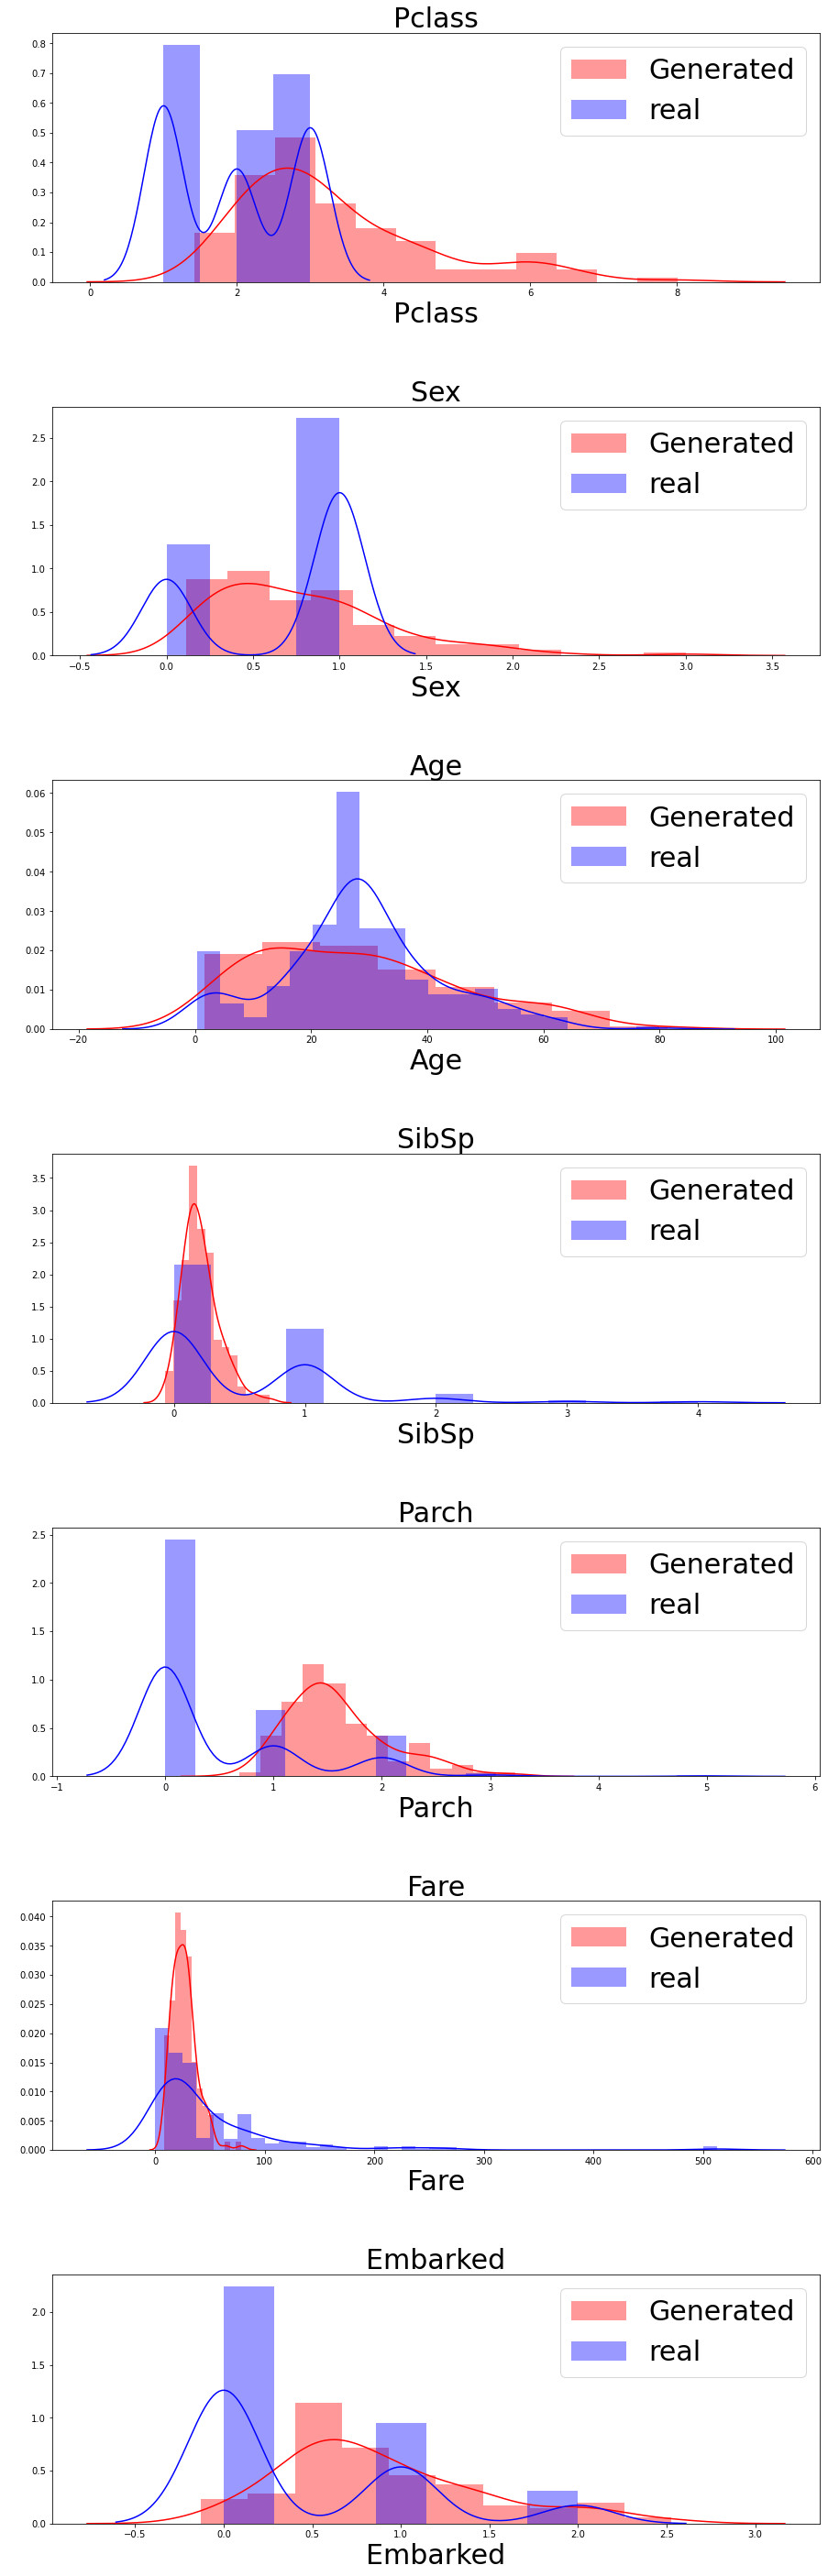

In [103]:
fig, axes = plt.subplots(7, 1, figsize=(15, 50))

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(7,1, n+1)
    sns.distplot(x = generated_df[col], color = 'red', label = 'Generated')
    sns.distplot(x = df[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 30)
    plt.xlabel(col, fontsize = 30)
    plt.title(col, fontsize = 30)
    plt.ylabel(' ')

plt.subplots_adjust(wspace=0.5,hspace=0.5)